In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Retention

In [2]:
## Load metadata
metadata = read_csv(os.path.join('data','metadata.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data','reject.csv'))
metadata = metadata[~metadata.Subject.isin(reject.query('Reject == 1').Subject)].reset_index(drop=True)

## Print statistics.
print(metadata.groupby('Session').Subject.nunique())

Session
1    103
2     94
3     92
4     90
Name: Subject, dtype: int64


## Section 2: Surveys

In [3]:
## Load survey data.
surveys = read_csv(os.path.join('data','surveys.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data','reject.csv'))
surveys = surveys[~surveys.Subject.isin(reject.query('Reject == 1').Subject)].reset_index(drop=True)

#### 2.1 Cross-Sectional Correlation Structure

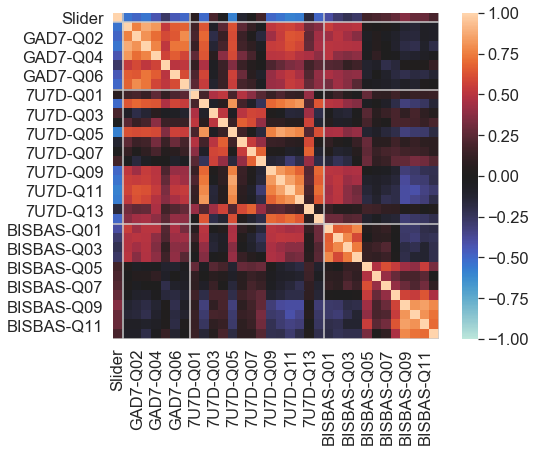

In [4]:
## Gather item columns.
cols = np.concatenate([surveys.filter(regex=f'{s}-Q').columns[:-1] for s in ['GAD7','7U7D','BISBAS']])
cols = np.append('Slider',cols)

## Compute correlation matrix.
corr = surveys.query('Session==1')[cols].corr(method='spearman')

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,6))

## Plot.
sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=True, ax=ax)
ax.vlines(np.cumsum([1,7,14,12]), 0, len(cols), color='0.8')
ax.hlines(np.cumsum([1,7,14,12]), 0, len(cols), color='0.8')

#### 2.2 Affective Slider

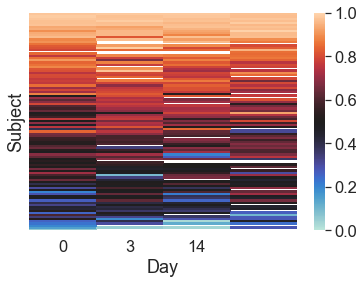

In [5]:
## Make pivot table.
mood = surveys.pivot_table('Slider','Subject','Session').values
mood = mood[np.argsort(np.nanmean(mood, axis=1))]

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot ratings.
sns.heatmap(mood, vmin=0, vmax=1, center=0.5, xticklabels=[0,3,14], yticklabels=[], ax=ax)
ax.set(xlabel='Day', ylabel='Subject')
ax.invert_yaxis()

#### 2.3 Generalized Anxiety Disorder Scale

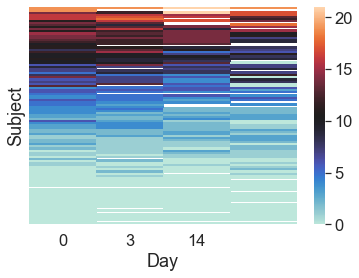

In [6]:
## Compute sum scores.
surveys['GAD7'] = surveys[surveys.filter(regex='GAD7-Q').columns[:-1]].sum(axis=1)

## Make pivot table.
gad7 = surveys.pivot_table('GAD7','Subject','Session').values
gad7 = gad7[np.argsort(np.nanmean(gad7, axis=1))]

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot scores.
sns.heatmap(gad7, vmin=0, vmax=21, center=10.5, xticklabels=[0,3,14], yticklabels=[], ax=ax)
ax.set(xlabel='Day', ylabel='Subject')
ax.invert_yaxis()

## Section 3: Behavior

In [7]:
## Load survey data.
data = read_csv(os.path.join('data','data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data','reject.csv'))
data = data[~data.Subject.isin(reject.query('Reject == 1').Subject)].reset_index(drop=True)

#### 3.1 Accuracy

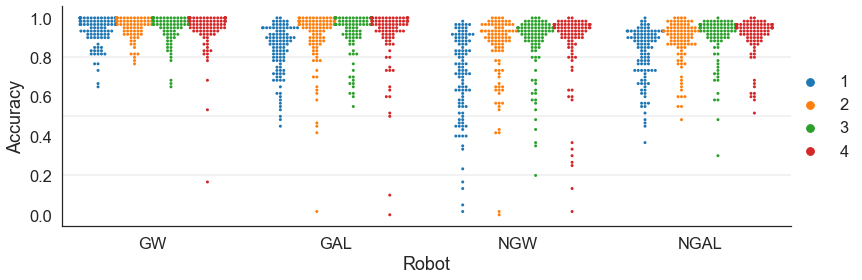

In [14]:
## Compute average within subjects / session / robot.
gb = data.groupby(['Subject','Session','Robot']).Accuracy.mean().reset_index()

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot accuracy.
sns.swarmplot('Robot', 'Accuracy', 'Session', data=gb, order=['GW','GAL','NGW','NGAL'], 
              size=3, dodge=True, ax=ax)
ax.axhline(0.8, lw=0.1, color='k', zorder=-1)
ax.axhline(0.5, lw=0.1, color='k', zorder=-1)
ax.axhline(0.2, lw=0.1, color='k', zorder=-1)
ax.legend(loc=7,bbox_to_anchor=(1.1,0.5), frameon=False)

sns.despine()
plt.tight_layout()

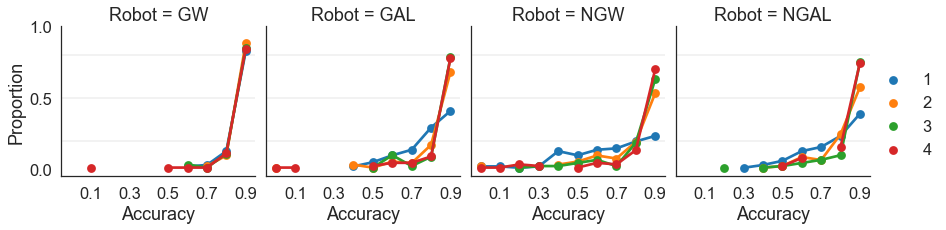

In [15]:
## Bin accuracy scores.
gb['Bin'] = gb.Accuracy.apply(lambda x: np.digitize(x, np.linspace(0.1,0.9,9)))

## Compute proportion of participants in each bin. 
gb = gb.groupby(['Session','Robot','Bin']).Subject.count().reset_index()
gb['Subject'] = gb.groupby(['Session','Robot']).Subject.apply(lambda x: x / x.sum())

## Initialize canvas.
g = sns.FacetGrid(gb, col='Robot', col_order=['GW','GAL','NGW','NGAL'])

## Plot binned accuracies.
g.map(sns.pointplot, 'Bin', 'Subject', 'Session', order=np.arange(10), hue_order=[1,2,3,4],
      palette=sns.color_palette(n_colors=4))
g.map(plt.axhline, y=0.8, lw=0.1, color='k', zorder=-1)
g.map(plt.axhline, y=0.5, lw=0.1, color='k', zorder=-1)
g.map(plt.axhline, y=0.2, lw=0.1, color='k', zorder=-1)

## Add detail.
g.set(xticks=np.arange(1,10,2), xticklabels=np.arange(0.1,1,0.2).round(1), xlabel='Accuracy', ylim=(-0.05,1))
g.axes[0,0].set_ylabel('Proportion')
g.add_legend();

In [13]:
gb

,Session,Robot,Bin,Subject
0,1,GAL,4,0.019417
1,1,GAL,5,0.048544
2,1,GAL,6,0.097087
3,1,GAL,7,0.135922
4,1,GAL,8,0.291262
...,...,...,...,...
95,4,NGW,5,0.011111
96,4,NGW,6,0.044444
97,4,NGW,7,0.033333
98,4,NGW,8,0.133333


#### 3.2 Response Times

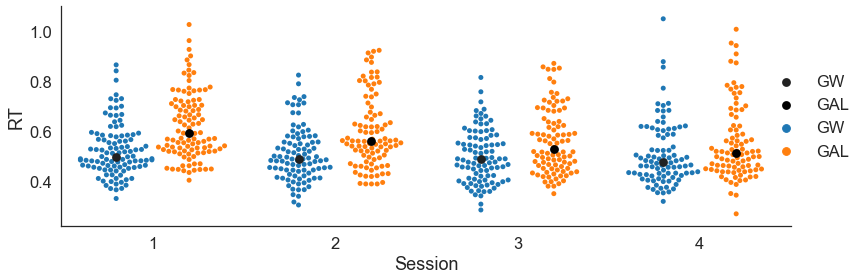

In [28]:
## Compute average within subjects / session / robot.
gb = data.groupby(['Subject','Session','Robot']).RT.median().reset_index()

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot accuracy.
sns.pointplot('Session', 'RT', 'Robot', data=gb, hue_order=['GW','GAL'], dodge=0.4, 
              ci=None, join=False, estimator=np.median, color='k', zorder=1e6, ax=ax)
sns.swarmplot('Session', 'RT', 'Robot', data=gb, hue_order=['GW','GAL'], dodge=True, zorder=0, ax=ax)

ax.legend(loc=7,bbox_to_anchor=(1.1,0.5), frameon=False)

sns.despine()
plt.tight_layout()

In [38]:
test = gb.pivot_table('RT',('Subject','Session'),'Robot')
test['Delta'] = test['GAL'] - test['GW']
test = test.reset_index()

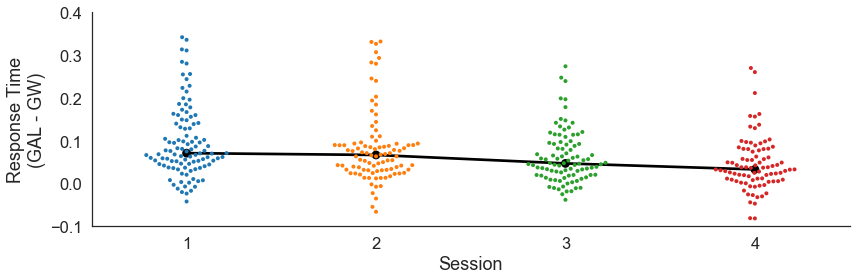

In [65]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
sns.swarmplot('Session', 'Delta', data=test, size=4, ax=ax)
sns.pointplot('Session', 'Delta', data=test, color='k', size=3, estimator=np.median, 
              ci=None, linewidth=1, ax=ax)

ax.set(ylim=(-0.1,0.4), ylabel='Response Time\n(GAL - GW)')
sns.despine()
plt.tight_layout()